In [4]:
import lifetimes

In [7]:
from math import sqrt


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly_express as px
from plotly.subplots import make_subplots

from sklearn.metrics import mean_absolute_error, confusion_matrix, f1_score, r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import KBinsDiscretizer

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [8]:
sns.set(rc={'figure.figsize':(13,10)})
pd.options.display.float_format = '{:,.2f}'.format

In [12]:
data = pd.read_csv('trans.csv', parse_dates=['POSTING_DATE']) 
data.sort_values(by=['ID','POSTING_DATE'], inplace=True)

data['ID'] = data['ID'].astype('string')
data['T_AMOUNT'] = data['T_AMOUNT'].astype('int32')
data['TRANS_SUBTYPE'] = data['TRANS_SUBTYPE'].astype('string')




data.sample(5)

,ID,TRANS_SUBTYPE,T_AMOUNT,POSTING_DATE
866605,857079,<NA>,-5318,2021-10-25
889665,842875,269014.0,172,2021-10-22
881353,827770,269014.0,42,2021-10-21
245762,262396,<NA>,125000,2021-07-22
246715,210126,1874.0,560,2021-07-12


<h1 style="color:tomato"> <b>EDA</b>

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260001 entries, 1152 to 1248383
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   ID             1260001 non-null  string        
 1   TRANS_SUBTYPE  755713 non-null   string        
 2   T_AMOUNT       1260001 non-null  int32         
 3   POSTING_DATE   1260001 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), string(2)
memory usage: 43.3 MB


In [14]:
data.describe()

,T_AMOUNT
count,"1,260,001.00"
mean,"4,679.60"
std,"81,118.90"
min,"-11,859,210.00"
25%,0.00
50%,600.00
75%,"5,500.00"
max,"22,106,151.00"


In [15]:
data.isnull().sum()

ID                    0
TRANS_SUBTYPE    504288
T_AMOUNT              0
POSTING_DATE          0
dtype: int64

In [16]:
# total number of transactions

len(data)

1260001

In [17]:
# number of customers

data['ID'].nunique()

1260001

In [18]:
# date range of the dataset : 

print(data.POSTING_DATE.min(), data.POSTING_DATE.max())
print(data.POSTING_DATE.max() - data.POSTING_DATE.min())

2020-06-02 00:00:00 2021-12-04 00:00:00
550 days 00:00:00


In [19]:

txns = data.groupby('POSTING_DATE')['T_AMOUNT'].aggregate(['count', 'sum']).reset_index()
txns.columns = ['Txn Date', 'No of Txns', 'Value of Txns']
txns.head()

,Txn Date,No of Txns,Value of Txns
0,2020-06-02,21,0
1,2020-06-03,13,0
2,2020-06-04,9,0
3,2020-06-05,4,0
4,2020-06-06,21,0


# Compute the RFM Dataframe


 - **Recency** : time between first and last transaction
 - **Frequency** : here frequency really refers to repeat frequency, i.e. the number of purchases beyond the initial one. i.e. repeat frequency = purchase counts - 1 )
 - **monetary value** : mean of all the transactions in the training periods
 - **T** : time between first purchase and end of calibration period

<h2 style="color:blue;"> More EDA and data preparation</h2>

In [22]:
# Dataset range
print('observation period start day' + " " + str(data.POSTING_DATE.min()))
print('observation period end day' + " " + str(data.POSTING_DATE.max()))

observation period start day 2020-06-02 00:00:00
observation period end day 2021-12-04 00:00:00


### Bin transactions by day

In [23]:
# Before binning

print(f"Total transactions: {len(df)}")
print(f"Total customers: {df['ID'].nunique()}")

Total transactions: 1260001
Total customers: 1260001


In [24]:
df = df.sort_values(['POSTING_DATE'], ascending=True).groupby(['ID', 'POSTING_DATE'], 
                                                                     as_index=False)['T_AMOUNT'].sum()
# After binning

print(f"Total transactions: {len(df)}")
print(f"Total customers: {df['ID'].nunique()}")

Total transactions: 1260001
Total customers: 1260001


In [25]:
# compute RFM using lifetimes summary data function
# use the (summary_data_from_transaction_data) function
summary_df = summary_data_from_transaction_data(df, 'ID', 'POSTING_DATE',
                                              monetary_value_col='T_AMOUNT')

summary_df.head()

,frequency,recency,T,monetary_value
ID,,,,
21,0.00,0.00,295.00,0.00
22,0.00,0.00,295.00,0.00
23,0.00,0.00,295.00,0.00
24,0.00,0.00,295.00,0.00
25,0.00,0.00,295.00,0.00


<p style="color:#FF8C00"> Create a distribution of frequency to understand frequency at the cutomer level</p>

count   1,260,001.00
mean            0.00
std             0.00
min             0.00
25%             0.00
50%             0.00
75%             0.00
max             0.00
Name: frequency, dtype: float64
------------------------------------


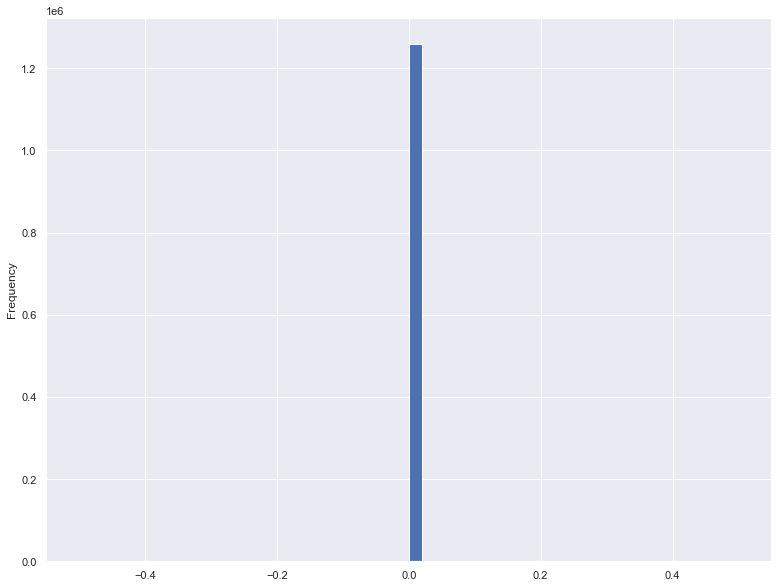

In [27]:
summary_df['frequency'].plot(kind='hist',bins=50)
print(summary_df['frequency'].describe())
print('------------------------------------')
onetimers = round(sum(summary_df['frequency'] == 0)/float(len(summary_df))*(100),2)


In [28]:
#penalizer_coef  passed to 0.01 to control parameters of the model

bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary_df['frequency'], summary_df['recency'], summary_df['T'])

<lifetimes.BetaGeoFitter: fitted with 1260001 subjects, a: 0.00, alpha: 1.04, b: 0.00, r: 0.00>

In [29]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.00,0.00,-0.00,0.00
alpha,1.04,2.45,-3.76,5.84
a,0.00,0.00,-0.01,0.01
b,0.00,0.00,-0.01,0.01


In [30]:
summary_df['probability_alive'] = bgf.conditional_probability_alive(summary_df['frequency'],summary_df['recency'],summary_df['T'])
summary_df.head()

,frequency,recency,T,monetary_value,probability_alive
ID,,,,,
21,0.00,0.00,295.00,0.00,1.00
22,0.00,0.00,295.00,0.00,1.00
23,0.00,0.00,295.00,0.00,1.00
24,0.00,0.00,295.00,0.00,1.00
25,0.00,0.00,295.00,0.00,1.00


In [31]:
summary_df.round()

,frequency,recency,T,monetary_value,probability_alive
ID,,,,,
21,0.00,0.00,295.00,0.00,1.00
22,0.00,0.00,295.00,0.00,1.00
23,0.00,0.00,295.00,0.00,1.00
24,0.00,0.00,295.00,0.00,1.00
25,0.00,0.00,295.00,0.00,1.00
...,...,...,...,...,...
3920430,0.00,0.00,0.00,0.00,1.00
3920440,0.00,0.00,0.00,0.00,1.00
3920450,0.00,0.00,0.00,0.00,1.00


In [32]:
summary_df[summary_df['probability_alive']!='1.0']

,frequency,recency,T,monetary_value,probability_alive
ID,,,,,
21,0.00,0.00,295.00,0.00,1.00
22,0.00,0.00,295.00,0.00,1.00
23,0.00,0.00,295.00,0.00,1.00
24,0.00,0.00,295.00,0.00,1.00
25,0.00,0.00,295.00,0.00,1.00
...,...,...,...,...,...
3920430,0.00,0.00,0.00,0.00,1.00
3920440,0.00,0.00,0.00,0.00,1.00
3920450,0.00,0.00,0.00,0.00,1.00


In [33]:
from collections import Counter
count_counter = Counter(summary_df['probability_alive'])
print(count_counter)

Counter({1.0: 1260001})
